# Minimal bias

In [1]:
import pandas as pd
import numpy as np

# Load data
people_df = pd.read_csv('va_persontrait_epihiper.txt', sep=",", skiprows=1)
infection_df = pd.read_csv('run_03_vadelta_rate_limited_ticks.metadata.fixed_dates.tsv', sep="\t", skiprows=[1])  # contains pid, hid, ...
household_df = pd.read_csv('va_household.csv')  # contains hid, hh_income, etc.

people_df = people_df.rename(columns={'pid': 'sim_pid'})
infection_df = infection_df.merge(people_df[['sim_pid', 'county_fips']], on='sim_pid', how='left')
infection_df = infection_df.merge(people_df[['sim_pid', 'hid']], on='sim_pid', how='left')
infection_df = infection_df.merge(people_df[['sim_pid', 'occupation_socp']], on='sim_pid', how='left')

# Load RUCC lookup
rucc_long = pd.read_csv("Ruralurbancontinuumcodes2023.csv",encoding="latin1")

# Pivot to wide format
rucc_wide = rucc_long.pivot_table(
    index=["FIPS", "State", "County_Name"],
    columns="Attribute",
    values="Value",
    aggfunc='first'
).reset_index()

# Rename for clarity
rucc_wide = rucc_wide.rename(columns={"RUCC_2023": "rucc_code"})
rucc_wide['rucc_code'] = pd.to_numeric(rucc_wide['rucc_code'], errors='coerce')

# Ensure both are string with 5-digit format
infection_df['county_fips'] = infection_df['county_fips'].astype(str).str.zfill(5)
rucc_wide['FIPS'] = rucc_wide['FIPS'].astype(str).str.zfill(5)

# Merge RUCC code into people
infection_df = infection_df.merge(
    rucc_wide[['FIPS', 'rucc_code']],
    left_on='county_fips',
    right_on='FIPS',
    how='left'
)

# Merge on household ID
df = infection_df.merge(household_df, on='hid', how='left')
df["age_group"] = (
    df["age_group"]
      .str.replace(r"[–—−]", "-", regex=True)   # en/em/minus → ASCII hyphen
      .str.strip()                              # trim spaces
)

In [2]:
import numpy as np
import pandas as pd

# Randomly assign 'asymptomatic' to 35% of the rows in the entire DataFrame
df['asymptomatic'] = np.random.rand(len(df)) < 0.35

print(df)
print(df['asymptomatic'].value_counts(normalize=True))


        virus         region country  division divisionExposure        date  \
0        ncov  North America     USA  Virginia         Virginia  2021-04-07   
1        ncov  North America     USA  Virginia         Virginia  2021-04-12   
2        ncov  North America     USA  Virginia         Virginia  2021-04-12   
3        ncov  North America     USA  Virginia         Virginia  2021-04-12   
4        ncov  North America     USA  Virginia         Virginia  2021-04-15   
...       ...            ...     ...       ...              ...         ...   
3444980  ncov  North America     USA  Virginia         Virginia  2021-10-03   
3444981  ncov  North America     USA  Virginia         Virginia  2021-10-03   
3444982  ncov  North America     USA  Virginia         Virginia  2021-10-03   
3444983  ncov  North America     USA  Virginia         Virginia  2021-10-03   
3444984  ncov  North America     USA  Virginia         Virginia  2021-10-03   

                                 strain      sim_pi

In [3]:
def compute_testing_probability_minimal_bias(row):
    p = 0.5  # baseline

    # Symptoms: only major factor
    if row['asymptomatic'] == True:
        p *= 0  # asymptomatic don't test
    elif row['asymptomatic'] == False:
        p *= 1  # proceed

    return min(max(p, 0), 1)

In [4]:
# Compute testing probabilities
df['test_prob'] = df.apply(compute_testing_probability_minimal_bias, axis=1)

# Simulate who came to test
df['tested_positive'] = np.random.binomial(1, df['test_prob'])

# Final linelist
linelist_df = df[df['tested_positive'] == 1].copy()

linelist_df.to_csv('simulated_test_positive_linelist_minimal_bias.csv', index=False)

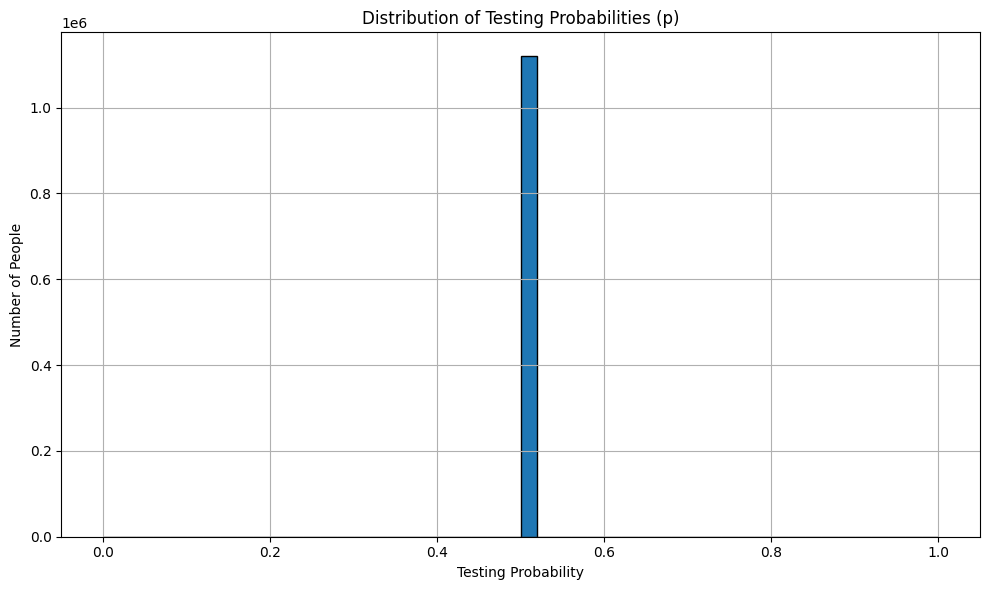

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(linelist_df['test_prob'], bins=50, edgecolor='black')
plt.title("Distribution of Testing Probabilities (p)")
plt.xlabel("Testing Probability")
plt.ylabel("Number of People")
plt.grid(True)
plt.tight_layout()
plt.show()

# Maximum bias

In [3]:
import numpy as np
import pandas as pd

# Reuse the same base weights from normal bias
BASE_WEIGHTS = {
    'income': {
        '<40k': 0.6,
        '40-70k': 0.8,
        '70-110k': 1.0,
        '>110k': 1.2
    },
    'age_group': {
        'Preschool (0-4)': 0.5,
        'Student (5-17)': 0.7,
        'Adult (18-49)': 1.0,
        'Older adult (50-64)': 1.2,
        'Senior (65+)': 1.4
    },
    'race': {
        'White': 1.0,
        'Asian': 0.85,
        'Black': 0.8,
        'Latino': 0.75,
        'Other': 0.7
    },
    'occupation': {
        '29': 1.4,    # Healthcare
        '35': 1.1,    # Food service
        '25': 1.2,    # Education
        '11': 1.0, '13': 1.0,  # Management/Business
        '41': 0.9, '53': 0.9,  # Sales/Transport
        '51': 0.85,            # Manufacturing
        'other': 0.7
    },
    'vehicles': {
        0: 0.7,
        1: 0.9,
        2: 1.0,
        'more': 1.0
    },
    'rucc': {
        'metro': 1.0,
        'suburban': 0.85,
        'rural': 0.7
    }
}

def apply_bias(w, bias_level='maximum'):
    if bias_level == 'maximum':
        return w ** 2
    else:
        return w

def compute_testing_probability_maximum_bias(row):
    p = 0.5  # baseline

    # Symptoms
    if row['asymptomatic'] == True:
        return 0.0

    # Income
    if pd.notnull(row['hh_income']):
        income = row['hh_income']
        if income < 40000:
            p *= apply_bias(BASE_WEIGHTS['income']['<40k'])
        elif income < 70000:
            p *= apply_bias(BASE_WEIGHTS['income']['40-70k'])
        elif income < 110000:
            p *= apply_bias(BASE_WEIGHTS['income']['70-110k'])
        else:
            p *= apply_bias(BASE_WEIGHTS['income']['>110k'])

    # Age
    age_w = BASE_WEIGHTS['age_group'].get(row['age_group'])
    if age_w is not None:
        p *= apply_bias(age_w)

    # Race
    race_w = BASE_WEIGHTS['race'].get(row['smh_race'])
    if race_w is not None:
        p *= apply_bias(race_w)

    # Occupation
    soc_code = str(row['occupation_socp'])
    major_group = soc_code[:2]
    if row['age_group'] in ['Adult (18-49)', 'Older adult (50-64)', 'Adult (18–49)', 'Older adult (50–64)']:
        occ_w = BASE_WEIGHTS['occupation'].get(major_group, BASE_WEIGHTS['occupation']['other'])
        p *= apply_bias(occ_w)

    # Vehicles
    v = int(row['vehicles'])
    if v == 0:
        p *= apply_bias(BASE_WEIGHTS['vehicles'][0])
    elif v == 1:
        p *= apply_bias(BASE_WEIGHTS['vehicles'][1])
    elif v == 2:
        p *= apply_bias(BASE_WEIGHTS['vehicles'][2])
    else:
        p *= apply_bias(BASE_WEIGHTS['vehicles']['more'])

    # Geography
    rucc = row['rucc_code']
    if rucc <= 3:
        p *= apply_bias(BASE_WEIGHTS['rucc']['metro'])
    elif rucc <= 6:
        p *= apply_bias(BASE_WEIGHTS['rucc']['suburban'])
    else:
        p *= apply_bias(BASE_WEIGHTS['rucc']['rural'])

    return min(max(p, 0), 1)


In [4]:
df['test_prob'] = df.apply(compute_testing_probability_maximum_bias, axis=1)
df['tested_positive'] = np.random.binomial(1, df['test_prob'])

linelist_df = df[df['tested_positive'] == 1].copy()
linelist_df.to_csv('simulated_test_positive_linelist_maximum_bias.csv', index=False)

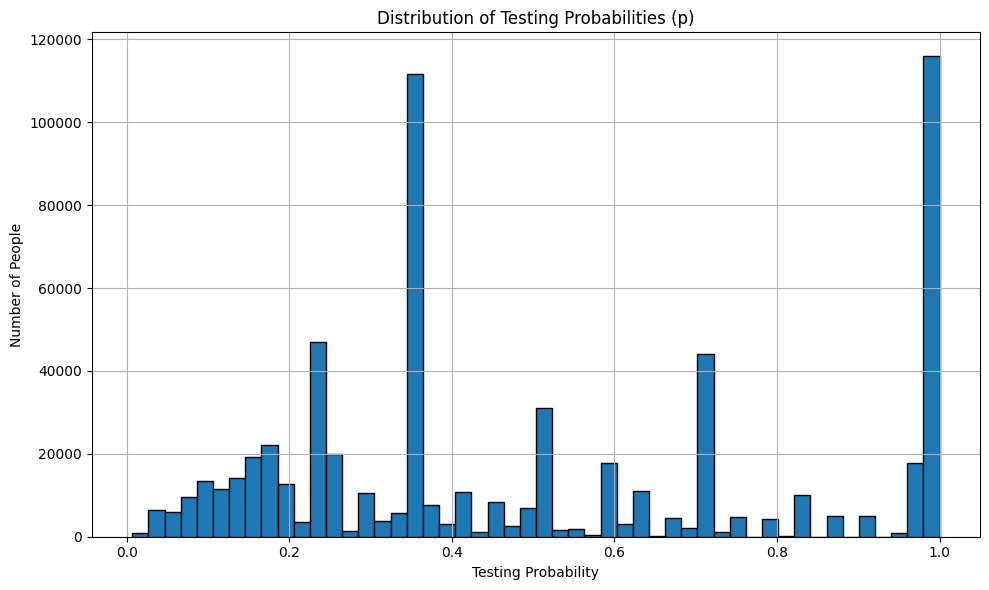

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(linelist_df['test_prob'], bins=50, edgecolor='black')
plt.title("Distribution of Testing Probabilities (p)")
plt.xlabel("Testing Probability")
plt.ylabel("Number of People")
plt.grid(True)
plt.tight_layout()
plt.show()

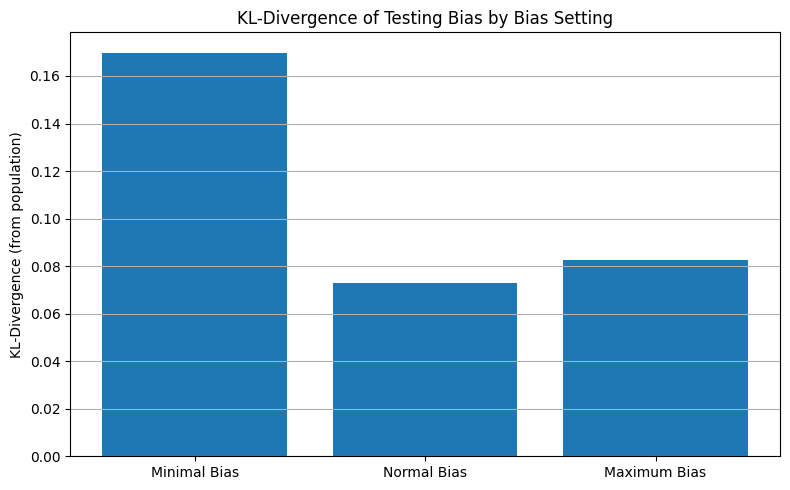

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import rel_entr

# Load datasets
pop_df = pd.read_csv("va_persontrait_epihiper.txt",skiprows=1)
minimal_df = pd.read_csv("simulated_test_positive_linelist_minimal_bias.csv")
normal_df = pd.read_csv("simulated_test_positive_linelist.csv")
maximum_df = pd.read_csv("simulated_test_positive_linelist_maximum_bias.csv")
pop_df["age_group"] = pop_df["age_group"].map({"p": "Preschool (0-4)", "s": "Student (5-17)", "a": "Adult (18-49)", "o": "Older adult (50-64)", "g": "Senior (65+)"})
pop_df = pop_df.rename(columns={"gender": "sex"})
pop_df["sex"] = pop_df["sex"].astype(str).map({"1": "male", "2": "female"})
pop_df["smh_race"] = pop_df["smh_race"].astype(str).map({"W": "White", "B": "Black", "L": "Latino", "A": "Asian", "O": "Other"})

# Function to get joint distribution
def joint_distribution(df):
    joint = df.groupby(['age_group', 'smh_race']).size()
    joint_prob = joint / joint.sum()
    return joint_prob

# Get joint distributions
P = joint_distribution(pop_df)         # True population
Q_min = joint_distribution(minimal_df)
Q_norm = joint_distribution(normal_df)
Q_max = joint_distribution(maximum_df)

# Align indices and fill missing with small value to avoid div/0
all_index = P.index.union(Q_min.index).union(Q_norm.index).union(Q_max.index)

P = P.reindex(all_index, fill_value=1e-10)
Q_min = Q_min.reindex(all_index, fill_value=1e-10)
Q_norm = Q_norm.reindex(all_index, fill_value=1e-10)
Q_max = Q_max.reindex(all_index, fill_value=1e-10)

# KL divergence
def kl_div(P, Q):
    return np.sum(rel_entr(P, Q))

kl_min = kl_div(P, Q_min)
kl_norm = kl_div(P, Q_norm)
kl_max = kl_div(P, Q_max)

# Plot
plt.figure(figsize=(8,5))
plt.bar(['Minimal Bias', 'Normal Bias', 'Maximum Bias'], [kl_min, kl_norm, kl_max])
plt.ylabel('KL-Divergence (from population)')
plt.title('KL-Divergence of Testing Bias by Bias Setting')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


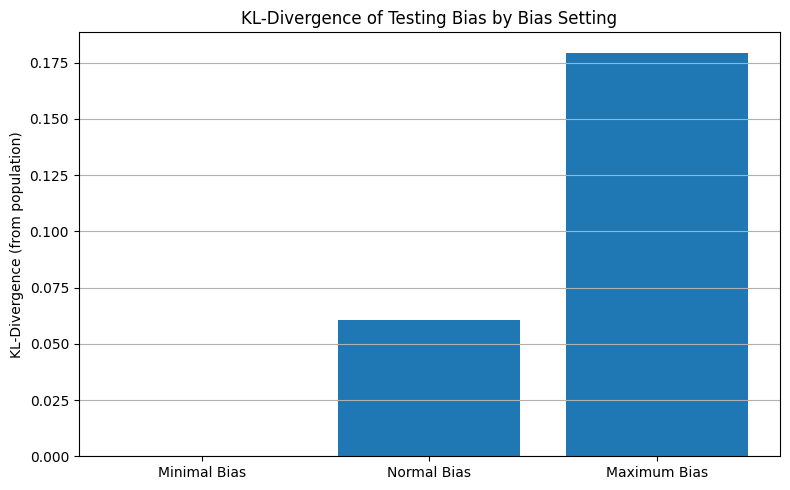

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import rel_entr

# Load datasets
pop_df = pd.read_csv('run_03_vadelta_rate_limited_ticks.metadata.fixed_dates.tsv', sep="\t", skiprows=[1])
minimal_df = pd.read_csv("simulated_test_positive_linelist_minimal_bias.csv")
normal_df = pd.read_csv("simulated_test_positive_linelist.csv")
maximum_df = pd.read_csv("simulated_test_positive_linelist_maximum_bias.csv")

# Function to get joint distribution
def joint_distribution(df):
    joint = df.groupby(['age_group', 'smh_race']).size()
    joint_prob = joint / joint.sum()
    return joint_prob

# Get joint distributions
P = joint_distribution(pop_df)         # True population
Q_min = joint_distribution(minimal_df)
Q_norm = joint_distribution(normal_df)
Q_max = joint_distribution(maximum_df)

# Align indices and fill missing with small value to avoid div/0
all_index = P.index.union(Q_min.index).union(Q_norm.index).union(Q_max.index)

P = P.reindex(all_index, fill_value=1e-10)
Q_min = Q_min.reindex(all_index, fill_value=1e-10)
Q_norm = Q_norm.reindex(all_index, fill_value=1e-10)
Q_max = Q_max.reindex(all_index, fill_value=1e-10)

# KL divergence
def kl_div(P, Q):
    return np.sum(rel_entr(P, Q))

kl_min = kl_div(P, Q_min)
kl_norm = kl_div(P, Q_norm)
kl_max = kl_div(P, Q_max)

# Plot
plt.figure(figsize=(8,5))
plt.bar(['Minimal Bias', 'Normal Bias', 'Maximum Bias'], [kl_min, kl_norm, kl_max])
plt.ylabel('KL-Divergence (from population)')
plt.title('KL-Divergence of Testing Bias by Bias Setting')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


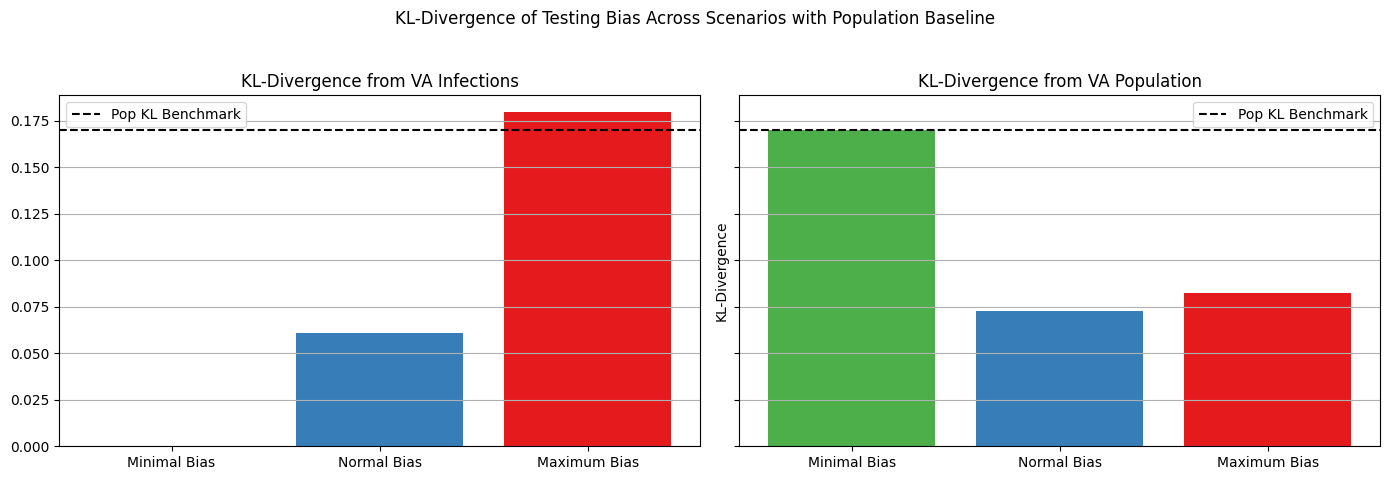

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import rel_entr

# ---- Helper Functions ----
def joint_distribution(df):
    joint = df.groupby(['age_group', 'smh_race']).size()
    joint_prob = joint / joint.sum()
    return joint_prob

def kl_div(P, Q):
    return np.sum(rel_entr(P, Q))

# ---- Load and Process VA Population ----
pop_df1 = pd.read_csv("va_persontrait_epihiper.txt", skiprows=1)
minimal_df = pd.read_csv("simulated_test_positive_linelist_minimal_bias.csv")
normal_df = pd.read_csv("simulated_test_positive_linelist.csv")
maximum_df = pd.read_csv("simulated_test_positive_linelist_maximum_bias.csv")

pop_df1 = pop_df1.rename(columns={"gender": "sex"})
pop_df1["age_group"] = pop_df1["age_group"].map({
    "p": "Preschool (0-4)", "s": "Student (5-17)", "a": "Adult (18-49)",
    "o": "Older adult (50-64)", "g": "Senior (65+)"
})
pop_df1["sex"] = pop_df1["sex"].astype(str).map({"1": "male", "2": "female"})
pop_df1["smh_race"] = pop_df1["smh_race"].astype(str).map({
    "W": "White", "B": "Black", "L": "Latino", "A": "Asian", "O": "Other"
})

# ---- VA Delta Population ----
pop_df2 = pd.read_csv("run_03_vadelta_rate_limited_ticks.metadata.fixed_dates.tsv", sep="\t", skiprows=[1])

# ---- Compute All Joint Distributions ----
P1 = joint_distribution(pop_df1)
P2 = joint_distribution(pop_df2)

all_index = P1.index.union(P2.index)
P1 = P1.reindex(all_index, fill_value=1e-10)
P2 = P2.reindex(all_index, fill_value=1e-10)

# ---- KL Between Populations ----
kl_pop = kl_div(P1, P2)

# ---- Testing Bias KLs (reindexing for fair comparison) ----
def get_bias_kls(pop_dist, *linelists):
    # Start with population index
    all_idx = pop_dist.index
    for df in linelists:
        all_idx = all_idx.union(joint_distribution(df).index)
    
    pop_dist = pop_dist.reindex(all_idx, fill_value=1e-10)
    
    kls = []
    for df in linelists:
        dist = joint_distribution(df).reindex(all_idx, fill_value=1e-10)
        kls.append(kl_div(pop_dist, dist))
    return kls

kl_vals1 = get_bias_kls(P1, minimal_df, normal_df, maximum_df)
kl_vals2 = get_bias_kls(P2, minimal_df, normal_df, maximum_df)

# ---- Plot Side by Side ----
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

bars = ['Minimal Bias', 'Normal Bias', 'Maximum Bias']
colors = ['#4daf4a', '#377eb8', '#e41a1c']

axes[1].bar(bars, kl_vals1, color=colors)
axes[1].axhline(kl_pop, linestyle='--', color='black', label='Pop KL Benchmark')
axes[1].set_title("KL-Divergence from VA Population")
axes[1].set_ylabel("KL-Divergence")
axes[1].grid(axis='y')
axes[1].legend()

axes[0].bar(bars, kl_vals2, color=colors)
axes[0].axhline(kl_pop, linestyle='--', color='black', label='Pop KL Benchmark')
axes[0].set_title("KL-Divergence from VA Infections")
axes[0].grid(axis='y')
axes[0].legend()

plt.suptitle("KL-Divergence of Testing Bias Across Scenarios with Population Baseline")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [19]:
sample_files = {
    "Normal Bias": "simulated_test_positive_linelist.csv",
    "Minimal Bias": "simulated_test_positive_linelist_minimal_bias.csv",
    "Maximum Bias": "simulated_test_positive_linelist_maximum_bias.csv",
}
population_file = "va_persontrait_epihiper.txt"


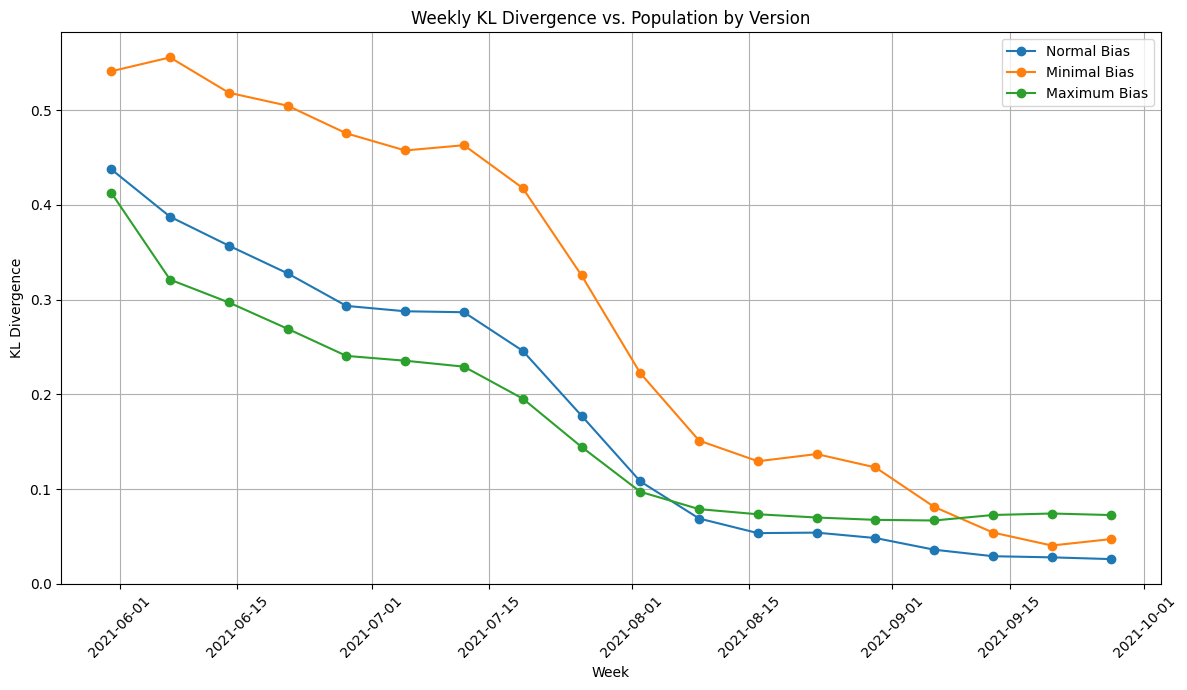

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

START_DATE = pd.to_datetime("2021-05-31")

# Load population and prepare strata
population_df = pd.read_csv(population_file,skiprows=1)
population_df["age_group"] = population_df["age_group"].map({"p": "Preschool (0-4)", "s": "Student (5-17)", "a": "Adult (18-49)", "o": "Older adult (50-64)", "g": "Senior (65+)"})
population_df = population_df.rename(columns={"gender": "sex"})
population_df["sex"] = population_df["sex"].astype(str).map({"1": "male", "2": "female"})
population_df["smh_race"] = population_df["smh_race"].astype(str).map({"W": "White", "B": "Black", "L": "Latino", "A": "Asian", "O": "Other"})
population_df['strata'] = population_df['age_group'] + " | " + population_df['smh_race']
population_dist = population_df['strata'].value_counts(normalize=True)

kl_data = []

# Loop through each version
for version_name, file_path in sample_files.items():
    sample_df = pd.read_csv(file_path, parse_dates=['date'])
    sample_df = sample_df[sample_df['date'] >= START_DATE]
    sample_df['strata'] = sample_df['age_group'] + " | " + sample_df['smh_race']
    sample_df['week'] = sample_df['date'].dt.to_period('W').apply(lambda r: r.start_time)

    for week, group in sample_df.groupby('week'):
        sample_dist = group['strata'].value_counts(normalize=True)
        all_strata = population_dist.index.union(sample_dist.index)
        sample_probs = sample_dist.reindex(all_strata, fill_value=1e-8)
        pop_probs = population_dist.reindex(all_strata, fill_value=1e-8)
        kl = entropy(sample_probs, pop_probs)
        kl_data.append({
            "version": version_name,
            "week": week,
            "kl_divergence": kl
        })

# Create DataFrame and plot
kl_df = pd.DataFrame(kl_data)

plt.figure(figsize=(12, 7))
for version in kl_df['version'].unique():
    subset = kl_df[kl_df['version'] == version]
    plt.plot(subset['week'], subset['kl_divergence'], label=version, marker='o')

plt.title('Weekly KL Divergence vs. Population by Version')
plt.xlabel('Week')
plt.ylabel('KL Divergence')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
